In [1]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle

import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import mne
from mne.preprocessing import ICA



Preproccesing Functions

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = custom_detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor =3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes])    # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.001 times smaller
    df[channel] = interpolated_values
    return df


Define the dataset

In [6]:
folder_name = 'f'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
duration = 40 
raw=[]
event=[]
BP=[]
PP=[]
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[:, 17]
            df_temp = s_temp.iloc[:, :8]
            # df_temp.plot(figsize=(10, 8))
            # plt.show()
            raw.append(df_temp)
            event.append(inst)
            
            # 1. Band Pass
            raw_bp = np.copy(df_temp)
            for column in range(8):
                raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
            # plt.plot(raw_bp)
            # plt.show()
            
            # 2. Artifact rejection
            BP_artifact_RJ = np.copy(raw_bp)
            for channel in range (8):
                BP_artifact_RJ= reject_artifacts(pd.DataFrame(BP_artifact_RJ), channel)
            # plt.plot(BP_artifact_RJ)
            # plt.show()
            
            # 3. Smoothing
            BP_artifact_RJ_SM=BP_artifact_RJ.copy()
            window_size = 10 
            for channel in range (8):
                # channel_data = BP_artifact_RJ_SM[channel, :]
                BP_artifact_RJ_SM= BP_artifact_RJ_SM.rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')
            # plt.plot(BP_artifact_RJ_SM)
            # plt.show()
            BP.append(BP_artifact_RJ_SM)
            
            # 4. Denoising and other preprocessing
            BP_artifact_RJ_SM.columns = selected_columns
            eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ_SM), col_names=selected_columns, n_clusters=[50]*len(selected_columns))
            # eeg_df_denoised.plot(subplots=True, figsize=(15, 10), title='Denoised EEG Data')
            # plt.show()
    
            PP.append(eeg_df_denoised)

In [7]:
fs=250
B_N=int(len(PP))
PP_NP=np.array(PP)
event=np.array(event).reshape(B_N*(df_temp.shape[0]), 1)
denoised=PP_NP.reshape(B_N*(df_temp.shape[0]), 8)  
pp_sig_event=np.concatenate((denoised, event), axis=1) 

labels=[] 
face = [] #lable=0
scene=[]#lable=1
for i in range(len(pp_sig_event)):
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    else:
        scene.append(pp_sig_event[i]) 
        labels.append(1)        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels)                  
print('event', event.shape,  'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)   

event (400000, 1) denoised (400000, 8) pp_sig_event (400000, 9) face (200000, 9) scene (200000, 9) labels (400000,)


(20, 50, 8)
(50, 8)
(20, 50, 8)
(50, 8) <class 'numpy.ndarray'>


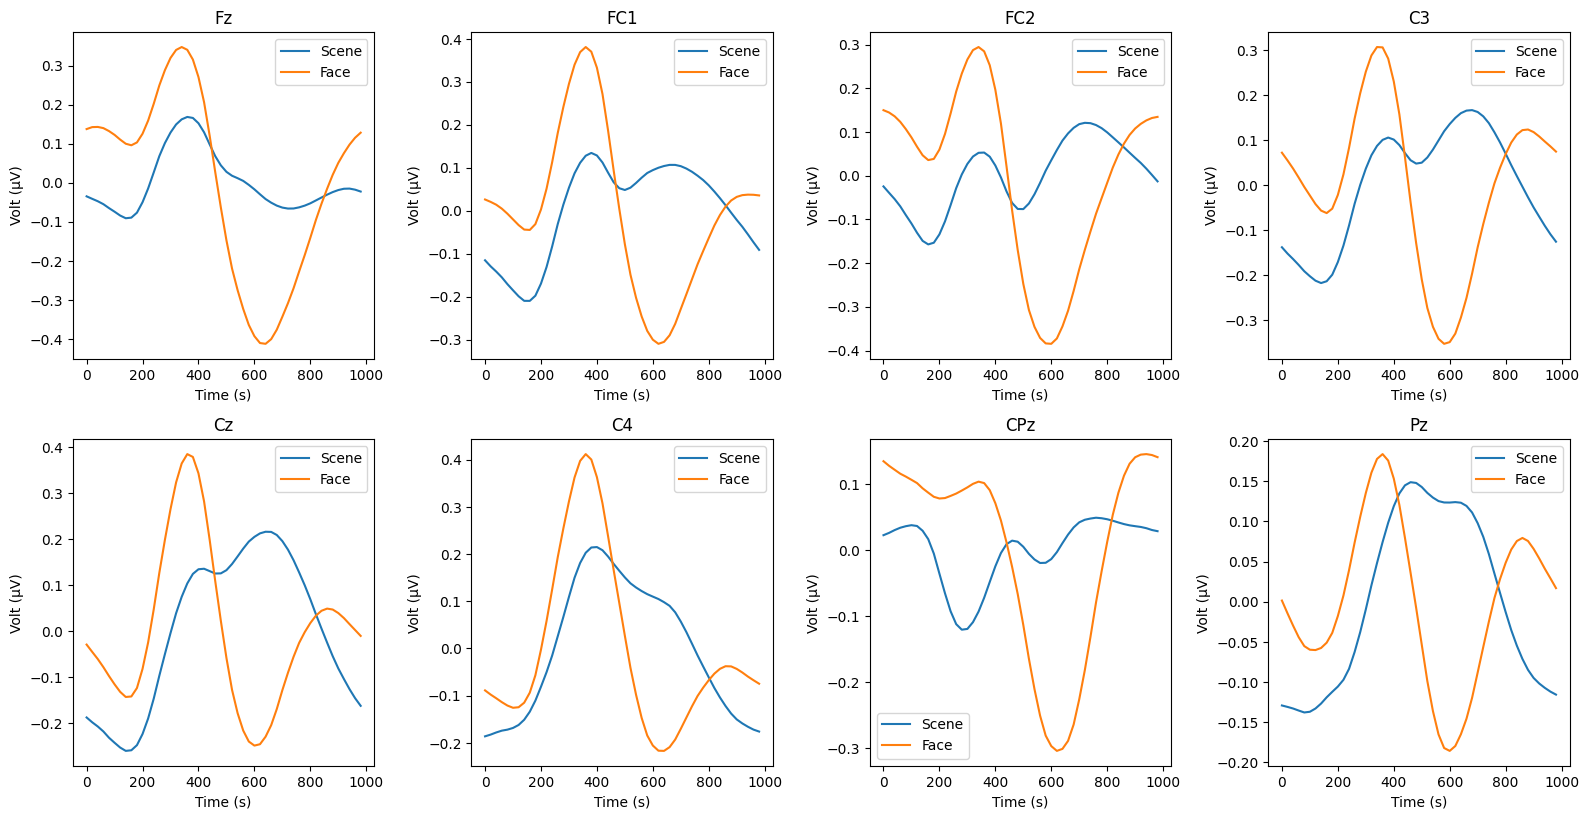

In [9]:
F_N=int(B_N/2)
S_N=int(B_N/2)
face_eeg_dada=face.reshape(F_N,int(df_temp.shape[0]/fs),50,5,9)
face_eeg_dada=face_eeg_dada[:,:,:,:,:8]
face_eeg_dada=face_eeg_dada.mean(axis=3)
face_eeg_dada=face_eeg_dada.mean(axis=1)
print(face_eeg_dada.shape)
face_mean=face_eeg_dada.mean(axis=0)
print(face_mean.shape)
scene_eeg_dada=scene.reshape(S_N,int(df_temp.shape[0]/fs),50,5,9)
scene_eeg_dada=scene_eeg_dada[:,:,:,:,:8]
scene_eeg_dada=scene_eeg_dada.mean(axis=3)
scene_eeg_dada=scene_eeg_dada.mean(axis=1)
print(scene_eeg_dada.shape)
scene_mean=scene_eeg_dada.mean(axis=0)
print(scene_mean.shape, type(scene_mean))

# time_list=[]
# for n in range(face_mean.shape[0]):
#     time = (n*5)/(fs)*1000
#     time_list.append(time)
# plt.figure(figsize=(16,16))
# for channel in range(8):
#     plt.subplot(4,4, channel + 1)  
#     plt.plot(time_list, face_mean[:, channel], label=f'Scene')
#     plt.plot(time_list, scene_mean[:, channel], label=f'Face')
#     plt.legend()
# plt.tight_layout()
# plt.show()     

time_list = []
channels_names = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']

for n in range(face_mean.shape[0]):
    time = (n*5)/(fs)*1000
    time_list.append(time)

plt.figure(figsize=(16,16))

for channel in range(8):
    plt.subplot(4, 4, channel + 1)  
    plt.plot(time_list, face_mean[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean[:, channel], label=f'Face')
    plt.title(channels_names[channel])  # Adding the channel name as the title
    plt.xlabel('Time (s)')               # Adding the x-axis label
    plt.ylabel('Volt (µV)')      # Adding the y-axis label
    plt.legend()

plt.tight_layout()
plt.show()
 

ERP Feature Extraction

In [100]:
c=(50/1000)
N180_window = (int(160*c),int(200*c))
P300_window = (int(280*c),int(320*c)) 
N500_window = (int(480*c), int(520*c))
N600_window = (int(580*c), int(620*c))
P700_window = (int(680*c),int(720*c))
P900_window = (int(880*c),int(920*c))

def extract_ERP_features(epoch):
    
    N180_region= epoch[N180_window[0]:N180_window[1]]
    P300_region = epoch[P300_window[0]:P300_window[1]]
    N500_region = epoch[N500_window[0]:N500_window[1]]
    N600_region = epoch[N600_window[0]:N600_window[1]]
    P700_region = epoch[P700_window[0]:P700_window[1]]
    P900_region = epoch[P900_window[0]:P900_window[1]]

    N180_amplitude= np.min(N180_region)
    N180_mean_amplitude = np.mean(N180_region)
    N180_latency = np.argmax(N180_region) + N180_window[0]
    
    P300_amplitude = np.max(P300_region)
    P300_mean_amplitude = np.mean(P300_region)
    P300_latency = np.argmax(P300_region) + P300_window[0]
    
    N500_amplitude = np.min(N500_region)
    N500_mean_amplitude = np.mean(N500_region)
    N500_latency = np.argmin(N500_region) + N500_window[0]
    
    N600_amplitude = np.min(N600_region)
    N600_mean_amplitude = np.mean(N600_region)
    N600_latency = np.argmin(N600_region) + N600_window[0]

    P700_amplitude = np.max(P700_region)
    P700_mean_amplitude = np.mean(P700_region)
    P700_latency = np.argmax(P700_region) + P700_window[0]
    
    P900_amplitude = np.max(P900_region)
    P900_mean_amplitude = np.mean(P900_region)
    P900_latency = np.argmin(P900_region) + P900_window[0]

    return [
        N180_mean_amplitude, 
        P300_mean_amplitude, 
        N500_mean_amplitude, 
        N600_mean_amplitude, 
        P700_mean_amplitude, 
        P900_mean_amplitude, 
    ]

frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40),
    'ERP':(0.4,40) }


# 'ERP':(0.4,40)
def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def extract_ERP_for_band(signal, band_limits, fs=250):
    band_filtered_signal = apply_bandpass_filter(signal, band_limits[0], band_limits[1], fs)
    return extract_ERP_features(band_filtered_signal)

def extract_all_band_ERPs(signal, frequency_bands):
    all_band_features = {}
    for band_name, band_limits in frequency_bands.items():
        all_band_features[band_name] = extract_ERP_for_band(signal, band_limits)
    return all_band_features

def extract_all_band_ERPs_to_array(signal, frequency_bands):
    all_band_features_list = []
    for band_name, band_limits in frequency_bands.items():
        erp_features_for_band = extract_ERP_for_band(signal, band_limits)
        all_band_features_list.extend(erp_features_for_band)
    return np.array(all_band_features_list)

def calculate_hilbert_features(signal, fs):
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

Feature Extraction

In [101]:
X=denoised.reshape(int(denoised.shape[0]/fs), fs*8)
label=labels.reshape(int(labels.shape[0]/fs), fs)
Y=np.squeeze(label[:,0])
data = X

BP_Power_FE = []
Hil_FE=[]
for i in range(data.shape[0]):
    eeg_signal = data[i, :].reshape(8, 250)  # reshaped to (8, 250)
    Power_feature_for_sample = []
    Hil_feature_for_sample = []
    for channel in range(8):
        channel_signal = eeg_signal[channel, :]
        power_for_channel = []
        hilbert_for_channel=[]
        for band, (low, high) in frequency_bands.items():
            filtered_signal = apply_bandpass_filter(channel_signal, low, high, fs)
            mean_amplitude = np.mean((filtered_signal)**2)
            hill=np.mean(calculate_hilbert_features(filtered_signal, fs))
            power_for_channel.append(mean_amplitude)
            hilbert_for_channel.append(hill)
        Power_feature_for_sample.append(power_for_channel)
        Hil_feature_for_sample.append(hilbert_for_channel) 
    BP_Power_FE.append(Power_feature_for_sample)
    Hil_FE.append(Hil_feature_for_sample)
BP_Power_FE_np = np.array(BP_Power_FE)
Hil_FE_np=np.array(Hil_FE)
print(BP_Power_FE_np.shape) 
print(Hil_FE_np.shape)

data_reshaped = X.reshape(int(denoised.shape[0]/fs), 8, 250)
ERP_FE = np.array([[extract_ERP_features(data_reshaped[i, j, :]) for j in range(8)] for i in range(int(denoised.shape[0]/fs))])
print(ERP_FE.shape)


(1600, 8, 6)
(1600, 8, 6)
(1600, 8, 6)


In [106]:
data_reshaped.shape

(1600, 8, 250)

In [103]:
combined_features = np.concatenate([Hil_FE_np, BP_Power_FE, ERP_FE], axis=2)
print(combined_features.shape)  # Should print (1600, 8, 11)

(1600, 8, 18)


In [104]:
af=combined_features.reshape(int(denoised.shape[0]/fs), 8*combined_features.shape[2])
af, Y = shuffle(af, Y)
print(af.shape, Y.shape)

# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(af, Y)
X_resampled= X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.int32)

# Split X and y into training and testing sets
X_touched, X_untouch, y_touch, y_untouch = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_touched, y_touch, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_untouch=tf.keras.utils.to_categorical(y_untouch, num_classes=2)


# Convert the data to a numerical type (float)
X_train = X_train.astype(np.float64)
print(X_train.shape)

# Convert one-hot-encoded labels to integer-encoded labels
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)
y_untouch = np.argmax(y_untouch, axis=-1)
print(y_train.shape, y_test.shape)


print('X_train:', X_train.shape, 'y_train:', y_train.shape, 'X_test:', X_test.shape, 'y_test:',
      y_test.shape, 'X_untouch:', X_untouch.shape, 'y_untouch:', y_untouch.shape )

(1600, 144) (1600,)
(1296, 144)
(1296,) (144,)
X_train: (1296, 144) y_train: (1296,) X_test: (144, 144) y_test: (144,) X_untouch: (160, 144) y_untouch: (160,)


In [105]:
from sklearn import svm
from joblib import dump
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
# Create a linear SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)
# Save the model to disk
filename = 'C:/Users/tnlab/OneDrive/Documents/GitHub/Neurofeedback-Based-BCI/SVM for Unicorn Data/my_svm_model.joblib'
dump(clf, filename)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print('Model accuracy: ', accuracy_score(y_test, y_pred))
report_svm_matrix = classification_report(y_test, y_pred)
print("Classification Report:")
print(report_svm_matrix)
report_svm = classification_report(y_test, y_pred, output_dict=True)

report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)

Model accuracy:  0.6111111111111112
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.74      0.62        61
           1       0.73      0.52      0.61        83

    accuracy                           0.61       144
   macro avg       0.63      0.63      0.61       144
weighted avg       0.64      0.61      0.61       144

